# Profiles of supergranule flow and vector potential

In [2]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pyfits
import plotc
import read_params
np.set_printoptions(precision=3)
import scipy.integrate
import dbyd2
%load_ext Cython
import matplotlib.ticker

def fitsread(f): return np.squeeze(pyfits.getdata(f))

In [3]:
c,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[1,2],unpack=True)
c.shape += (1,)
rho.shape += (1,)
c = c/100 # Convert to m/s

vx_analytical = fitsread('true_vx.fits')
vz_analytical = fitsread('true_vz.fits')
true_psi = fitsread('true_psi.fits')
Lregular = 30 #Mm, required to convert psi to Mm, see driver.f90
true_psi *= Lregular

Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
z=(z-1)*695.8

def ind_x(x): return int((x/Lx+1/2)*nx)
def ind_z(z_coord): return abs(z-z_coord).argmin()

z_surf=ind_z(0)

Let's derive the velocity fields from the vector potential. In Cartesian coordinates the velocity field is related to the potential through 

$$ v_{x}	=	-\frac{1}{\rho}\partial_{z}\left[\rho c\psi\right], \\
v_{z}	=	\frac{1}{\rho}\partial_{x}\left[\rho c\psi\right]. $$

In [4]:
dbyd2_z = np.zeros((1,)+z.shape,order='F')
dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)

def ddz(arr): return np.gradient(arr)[0]/np.gradient(z)[:,np.newaxis]
def ddz_dbyd2(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

In [5]:
%%cython
import numpy as np
cimport numpy as np
import scipy.fftpack
import read_params
import scipy.interpolate

Lx = read_params.get_xlength()

cpdef fft_deriv_x(arr):
    cdef int zind
    cdef np.ndarray[np.float64_t, ndim=2] darr = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] az
    for zind,az in enumerate(arr):
        darr[zind]=scipy.fftpack.diff(az,period=float(Lx))
    return darr

cpdef fft_int_x(arr):
    cdef int zind,nx
    cdef float az_mean
    nx = arr.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] darr = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] x=np.linspace(-Lx/2.,Lx/2.,nx,endpoint=False)
    cdef np.ndarray[np.float64_t,ndim=1] az
    
    for zind,az in enumerate(arr):
        az_mean = np.mean(az)
        darr[zind]=scipy.fftpack.diff(az-az_mean,period=Lx,order=-1)
        darr[zind]+=az_mean*(x+Lx/2.)
        
    return darr

cpdef spline_int_z(arr):
    cdef int xind,zind,nx,nz
    nx = arr.shape[1]
    nz = arr.shape[0]
    cdef np.ndarray[np.float64_t, ndim=2] arr_int = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] z
    z = np.loadtxt(read_params.get_solarmodel(),usecols=[0]); z=(z-1.)*695.8
    cdef float z_lower=z[0]
    cdef np.ndarray[np.float64_t,ndim=1] arr_x_zlow,z_low
    
    for xind in xrange(nx):
        for zind in xrange(5,nz):
            arr_x_zlow = arr[:zind,xind]
            z_low = z[:zind]
            s=scipy.interpolate.UnivariateSpline(z_low,arr_x_zlow)
            arr_int[zind,xind]=s.integral(z_lower,z[zind])
            
    return arr_int

/home/jishnu/.local/lib/python2.7/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [6]:
vx_from_psi_dbyd2 = -1/rho*ddz_dbyd2(rho*c*true_psi)
vz_from_psi_fft = 1/rho*fft_deriv_x(rho*c*true_psi)

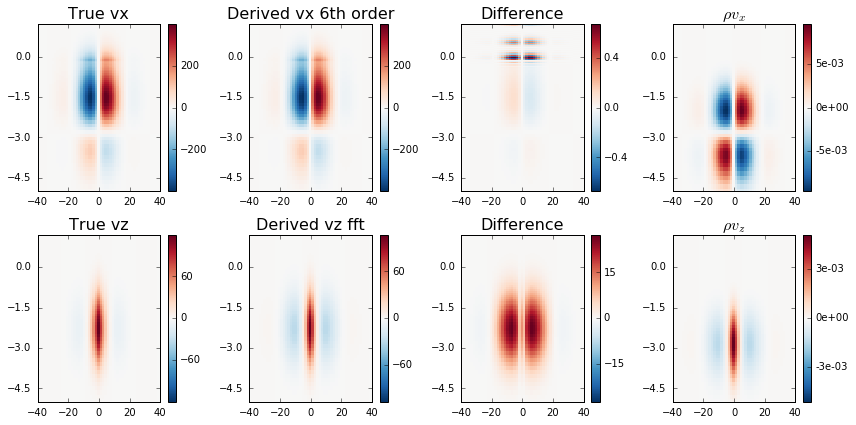

In [27]:
gl=plotc.gridlist(2,4)

plotc.colorplot(vx_analytical,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)
plotc.colorplot(vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Derived vx 6th order",fontsize=16)
plotc.colorplot(vx_analytical-vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)
plotc.colorplot(rho*vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title(r"$\rho v_x$",fontsize=16)

plotc.colorplot(vz_analytical,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)
plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Derived vz fft",fontsize=16)
plotc.colorplot(vz_analytical-vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)
plotc.colorplot(rho*vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title(r"$\rho v_z$",fontsize=16)

plt.gcf().set_size_inches(12,6);
plt.tight_layout()

We see that the true $v_z$ is significantly different from the derived $v_z$. The normalized mean square difference is

In [15]:
print "vz misft lower limit",np.sum((vz_analytical-vz_from_psi_fft)**2)/np.sum(vz_analytical**2)
print "vx misft lower limit",np.sum((vx_analytical-vx_from_psi_dbyd2)**2)/np.sum(vx_analytical**2)

vz misft lower limit 0.225559693445
vx misft lower limit 8.02318138268e-07


The vector potential that gives rise to these velocity fields can be computed in polar as well as Cartesian coordinates. The difference is that the vector potential is along $\mathbf{e}_\phi$ in polar and $\mathbf{e}_y$ in Cartesian. 

### Cartesian coordinates
 
 $$ \psi\left(x,z\right)=\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{-L_x/2}^{x}dx^{\prime}\,\rho\left(z\right)v_{z}\left(x^{\prime},z\right).$$
 
or alternately in terms of $v_x$
 
 $$ \psi\left(x,z\right)=-\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{z_{b}}^{z}dz^{\prime}\,\rho\left(z^{\prime}\right)v_{x}\left(x,z^{\prime}\right).$$
 
Let us do $v_z$ first

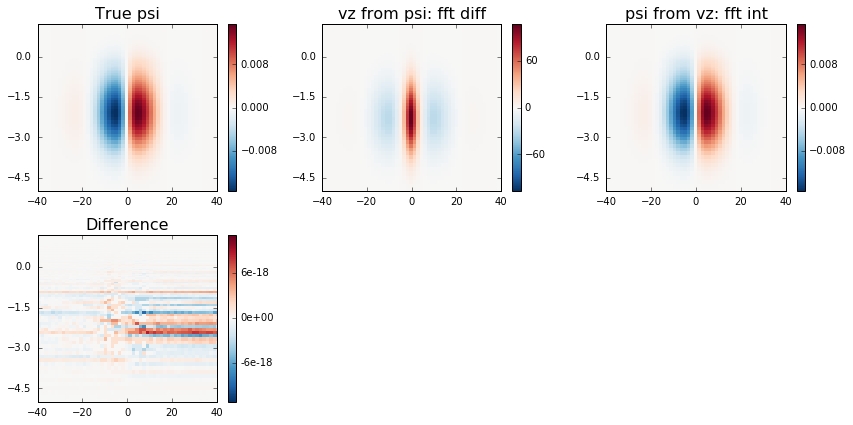

In [16]:
gl=plotc.gridlist(2,3)

plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("vz from psi: fft diff",fontsize=16)

psi_from_vz_from_psi = fft_int_x(rho*vz_from_psi_fft)/(rho*c)
plotc.colorplot(psi_from_vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi from vz: fft int",fontsize=16)

plotc.colorplot(true_psi-psi_from_vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plt.gcf().set_size_inches(12,6)
plt.tight_layout()

psi_from_vz_from_psi=None

#### Let us try the same with $v_x$

In [19]:
psi_from_analytical_vx_trapz=-scipy.integrate.cumtrapz(rho*vx_analytical,x=z,axis=0,initial=0)/(rho*c)
psi_from_numerical_vx_trapz=-scipy.integrate.cumtrapz(rho*vx_from_psi_dbyd2,x=z,axis=0,initial=0)/(rho*c)
# psi_from_analytical_vx_spline=-spline_int_z(rho*vx_analytical)/(rho*c)
# psi_from_numerical_vx_spline=-spline_int_z(rho*vx_from_psi_dbyd2)/(rho*c)

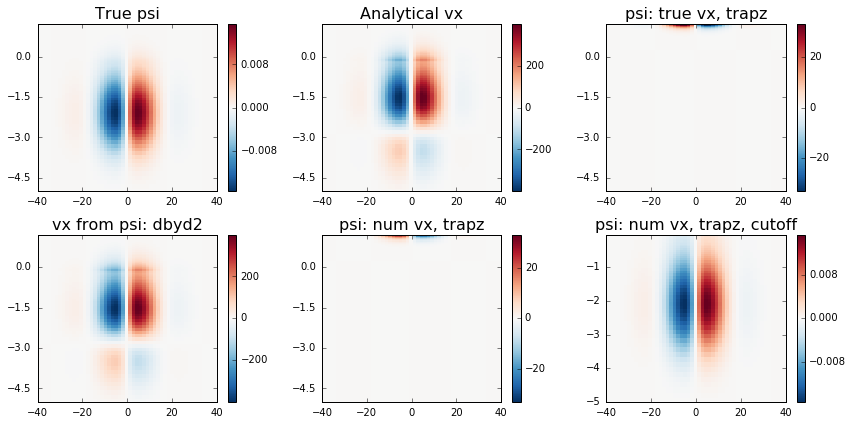

In [20]:
gl=plotc.gridlist(2,3)

plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16);

plotc.colorplot(vx_analytical,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Analytical vx",fontsize=16);

plotc.colorplot(psi_from_analytical_vx_trapz,x=x,y=z,xr=[-40,40],yr=[-5,None],
                centerzero=True,sp=next(gl));
plt.title("psi: true vx, trapz",fontsize=16);

plotc.colorplot(vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("vx from psi: dbyd2",fontsize=16);

plotc.colorplot(psi_from_numerical_vx_trapz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi: num vx, trapz",fontsize=16);

upper_cutoff=ind_z(0)
plotc.colorplot(psi_from_numerical_vx_trapz[:upper_cutoff],x=x,y=z[:upper_cutoff],
                xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi: num vx, trapz, cutoff",fontsize=16);

# plotc.colorplot(psi_from_analytical_vx_spline,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
# plt.title("psi: true vx, spline",fontsize=16);

# plotc.colorplot(psi_from_numerical_vx_spline,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
# plt.title("psi: num vx, spline",fontsize=16);

plt.gcf().set_size_inches(12,6)
plt.tight_layout()

Inspecting $\rho v_x$

rho vx max 0.00539836189346
rho vx min -0.00504031574527


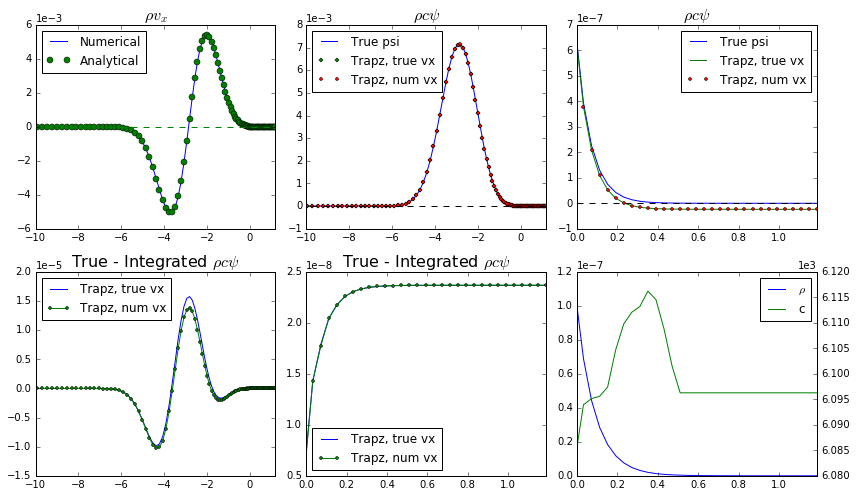

In [28]:
gl=plotc.gridlist(2,3)

x_cut_ind = ind_x(3) # Mm to pixel

plt.subplot(next(gl))
plt.plot(z,(rho*vx_from_psi_dbyd2)[:,x_cut_ind],label="Numerical");
plt.plot(z,(rho*vx_analytical)[:,x_cut_ind],'o',label="Analytical");
plt.plot(z,np.zeros_like(z),'g--');
plt.legend(loc="best")
plt.xlim(-10,z[-1]);
plt.title(r"$\rho v_x$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

print "rho vx max",(rho*vx_from_psi_dbyd2)[:,x_cut_ind].max()
print "rho vx min",(rho*vx_from_psi_dbyd2)[:,x_cut_ind].min()

plt.subplot(next(gl))
plt.plot(z,(rho*c*true_psi)[:,x_cut_ind],label="True psi");
plt.plot(z,(rho*c*psi_from_analytical_vx_trapz)[:,x_cut_ind],label="Trapz, true vx",
        marker="D",markersize=3,ls="None");
plt.plot(z,(rho*c*psi_from_numerical_vx_trapz)[:,x_cut_ind],label="Trapz, num vx",
         marker='o',markersize=3,ls="None");
plt.plot(z,np.zeros_like(z),color='k',ls="dashed")
plt.xlim(-10,z[-1]);
plt.title(r"$\rho c \psi$",fontsize=16)
plt.legend(loc="best")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

z_cutoff_ind=ind_z(0)
plt.subplot(next(gl))
plt.plot(z[z_cutoff_ind:],(rho*c*true_psi)[z_cutoff_ind:,x_cut_ind],label="True psi");
plt.plot(z[z_cutoff_ind:],(rho*c*psi_from_analytical_vx_trapz)[z_cutoff_ind:,x_cut_ind],label="Trapz, true vx");
plt.plot(z[z_cutoff_ind:],(rho*c*psi_from_numerical_vx_trapz)[z_cutoff_ind:,x_cut_ind],label="Trapz, num vx",
         marker='o',markersize=3,ls="None");
plt.xlim(0,z[-1]);
plt.plot(np.zeros_like(z),'k--');
plt.title(r"$\rho c \psi$",fontsize=16)
plt.legend(loc="best")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.subplot(next(gl))
plt.plot(z,(rho*c*(true_psi-psi_from_analytical_vx_trapz))[:,x_cut_ind],label="Trapz, true vx");
plt.plot(z,(rho*c*(true_psi-psi_from_numerical_vx_trapz))[:,x_cut_ind],label="Trapz, num vx",
        marker='o',markersize=3);
plt.xlim(-10,z[-1]);
plt.legend(loc="best")
plt.title(r"True - Integrated $\rho c \psi$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.subplot(next(gl))
plt.plot(z[z_cutoff_ind:],(rho*c*(true_psi-psi_from_analytical_vx_trapz))[z_cutoff_ind:,x_cut_ind],
         label="Trapz, true vx");
plt.plot(z[z_cutoff_ind:],(rho*c*(true_psi-psi_from_numerical_vx_trapz))[z_cutoff_ind:,x_cut_ind],
         label="Trapz, num vx",marker='o',markersize=3);
plt.xlim(0,z[-1]);
plt.legend(loc="best")
plt.title(r"True - Integrated $\rho c \psi$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

z_cutoff_ind=ind_z(0)
plt.subplot(next(gl))
l1=plt.plot(z[z_cutoff_ind:],rho.flatten()[z_cutoff_ind:],'b',label=r"$\rho$")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.gca().twinx()
l2=plt.plot(z[z_cutoff_ind:],c.flatten()[z_cutoff_ind:],'g',label="c")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.xlim(0,z[-1]);
lines=[l for l in l1+l2]
labels=[l.get_label() for l in lines]
plt.legend(lines,labels,loc="best")

plt.gcf().set_size_inches(12,7);
plt.tight_layout()

Integrating $v_x$ is a numerical problem

# Psi with cutoff

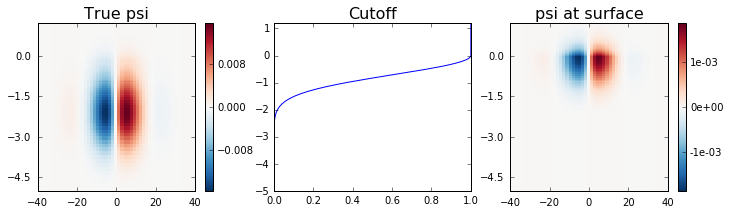

In [10]:
plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=131);
plt.title("True psi",fontsize=16)

cutoff = z**2/1
cutoff[cutoff>100]=100
cutoff[z_surf:]=0.
cutoff = np.exp(-cutoff)
cutoff.shape += (1,)
psi_above_surface = true_psi.copy()
psi_above_surface[:z_surf] = np.tile(np.atleast_2d(psi_above_surface[z_surf]),(z_surf,1))
psi_above_surface*=cutoff

plt.subplot(132)
plt.plot(cutoff,z);
plt.ylim(-5,z[-1])
plt.title("Cutoff",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=133);
plt.title("psi at surface",fontsize=16)

plt.gcf().set_size_inches(12,3)

Velocity corresponding to surface matched potential

In [11]:
vx_starting = -ddz_dbyd2(rho*c*psi_above_surface)/rho
vz_starting = fft_deriv_x(rho*c*psi_above_surface)/rho

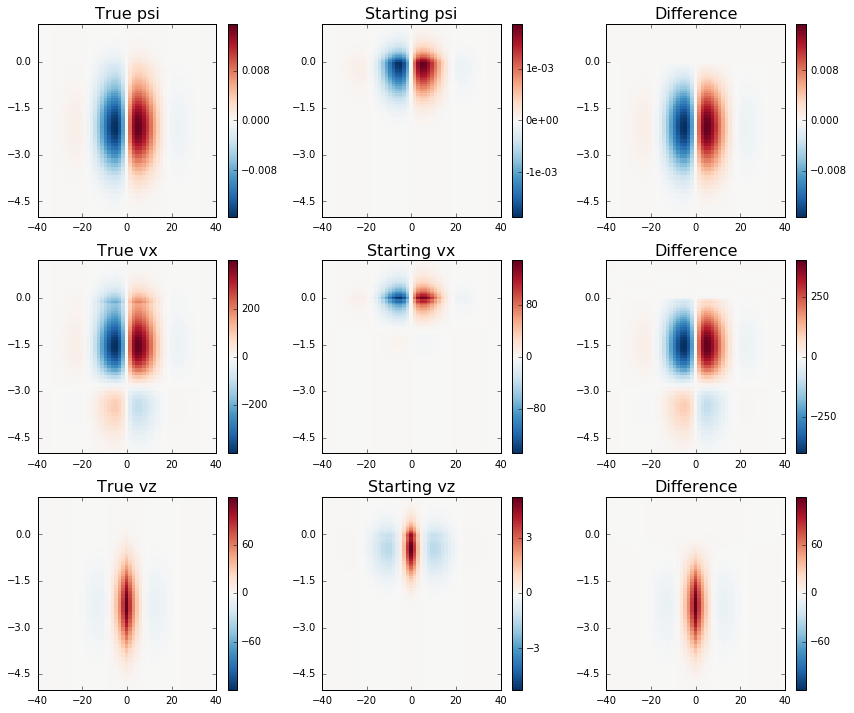

In [12]:
gl=plotc.gridlist(3,3)

plotc.colorplot(true_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting psi",fontsize=16)

plotc.colorplot(true_psi-psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vx,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)

plotc.colorplot(vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vx",fontsize=16)

plotc.colorplot(vx-vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)

plotc.colorplot(vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vz",fontsize=16)

plotc.colorplot(vz-vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plt.gcf().set_size_inches(12,10)
plt.tight_layout()

In [16]:
pyfits.writeto("model_psi_ls00.fits",psi_above_surface,clobber=True)
pyfits.writeto("vx_surface_constrained.fits",vx_starting,clobber=True)
pyfits.writeto("vz_surface_constrained.fits",vz_starting,clobber=True)

/usr/local/lib/python2.7/dist-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'vx_00.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/usr/local/lib/python2.7/dist-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'vz_00.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
